# Tutoría N°1: Modelos de Endamble P.I
### Gabriel Céspedes

## Actividad: Predicción de Incumplimiento de Pago de Tarjetas de Crédito

En el sector financiero, predecir si un cliente incumplirá con sus pagos es crucial para la gestión de riesgos y la toma de decisiones. Se necesita construir un modelo de Machine Learning capaz de identificar a los clientes con alta probabilidad de incumplir sus pagos de tarjeta de crédito. El dataset utilizado se basa en datos de clientes entre abril y septiembre.

### Objetivo: 
Construir un modelo de clasificación que prediga la variable ```default.payment.next.month``` (Incumplimiento de pago en el próximo mes), donde ```1``` indica que el cliente incumplirá y ```0``` que cumplirá.

### Descripción del dataset:
El dataset ```UCI_Credit_Card.csv``` contiene 25 variables que incluyen información demográfica, de crédito, historial de pagos y estados de cuenta de clientes. Algunas de las variables son:

- LIMIT_BAL: Monto de crédito otorgado
- SEX: Género del cliente
- EDUCATION: Nivel educativo
- MARRIAGE: Estado Civil
- AGE: Edad del cliente
- PAY_0 a PAY_6: Estado de pago en los últimos 6 meses (con -1 para pago puntual, 1 para un mes de retraso, etc.).
- BILL_AMT1 a BILL_AMT6: Monto del estado de cuenta en los últimos 6 meses
- PAY_AMT1 a PAY_AMT6: Monto del pago anterior en los últimos 6 meses

### Tareas a realizar:
1. Importa las librerías necesarias y el dataset, analiza las variables utilizando visualizaciones, considera posibles correlaciones y representalas en un heatmap.
2. Desarrolla un modelo de árbol de decisión sin modificar sus hiperparámetros y obtén sus métricas de desempeño. Mejora este modelo usando búsqueda por grilla con 5 kfold: ```max_depth: [5, 10, 15, 20, 25]```, ```min_samples_split: [0.01, 0.02, 0.03, 0.04]```
Da a conocer el desempeño del modelo en los datos de entrenamiento y en los de prueba.
3. Balancea las clases usando ```SMOTE``` para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de prueba.
4. Implementa un modelo de Bagging usando modelos heterogéneos con distintos estimadores, considera 200 muestras boostrap. Debes calibrar la importancia de los modelos, considera para este caso el mejor f1-score. Para realizar esta tarea utiliza la función ```baging_het``` del archivo ```util_bagging.py```.
5. Implementa un modelo de ensamble Random Forest usando como hiperparámetro ```n_estimatos = 45```. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de prueba.
6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores: ```n_estimators```: 50 - 300 con paso de 25, ```max_features: ['sqrt', 'log2', None]```. Muestra los mejores hiperparámetros encontrados, la estimación de desempeño de los datos OOB y despliega los cuatro atributos más importantes.
7. Usando el modelo Random Forest con sus hiperparámetros ajustados, muestre los 15 clientes que presentan la mayor probabilidad de no pagar la tarjeta de crédito el próximo mes.

1. Importa las librerías necesarias y el dataset, analiza las variables utilizando visualizaciones, considera posibles correlaciones y representalas en un heatmap.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/UCI_Credit_Card.csv')
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
from moduls.exploracion6 import calidad_datos, graficos, no_atipicos, correlacion, matriz_correlacion, boxplots

In [8]:
columns = list(df.columns)
columns.remove('ID')

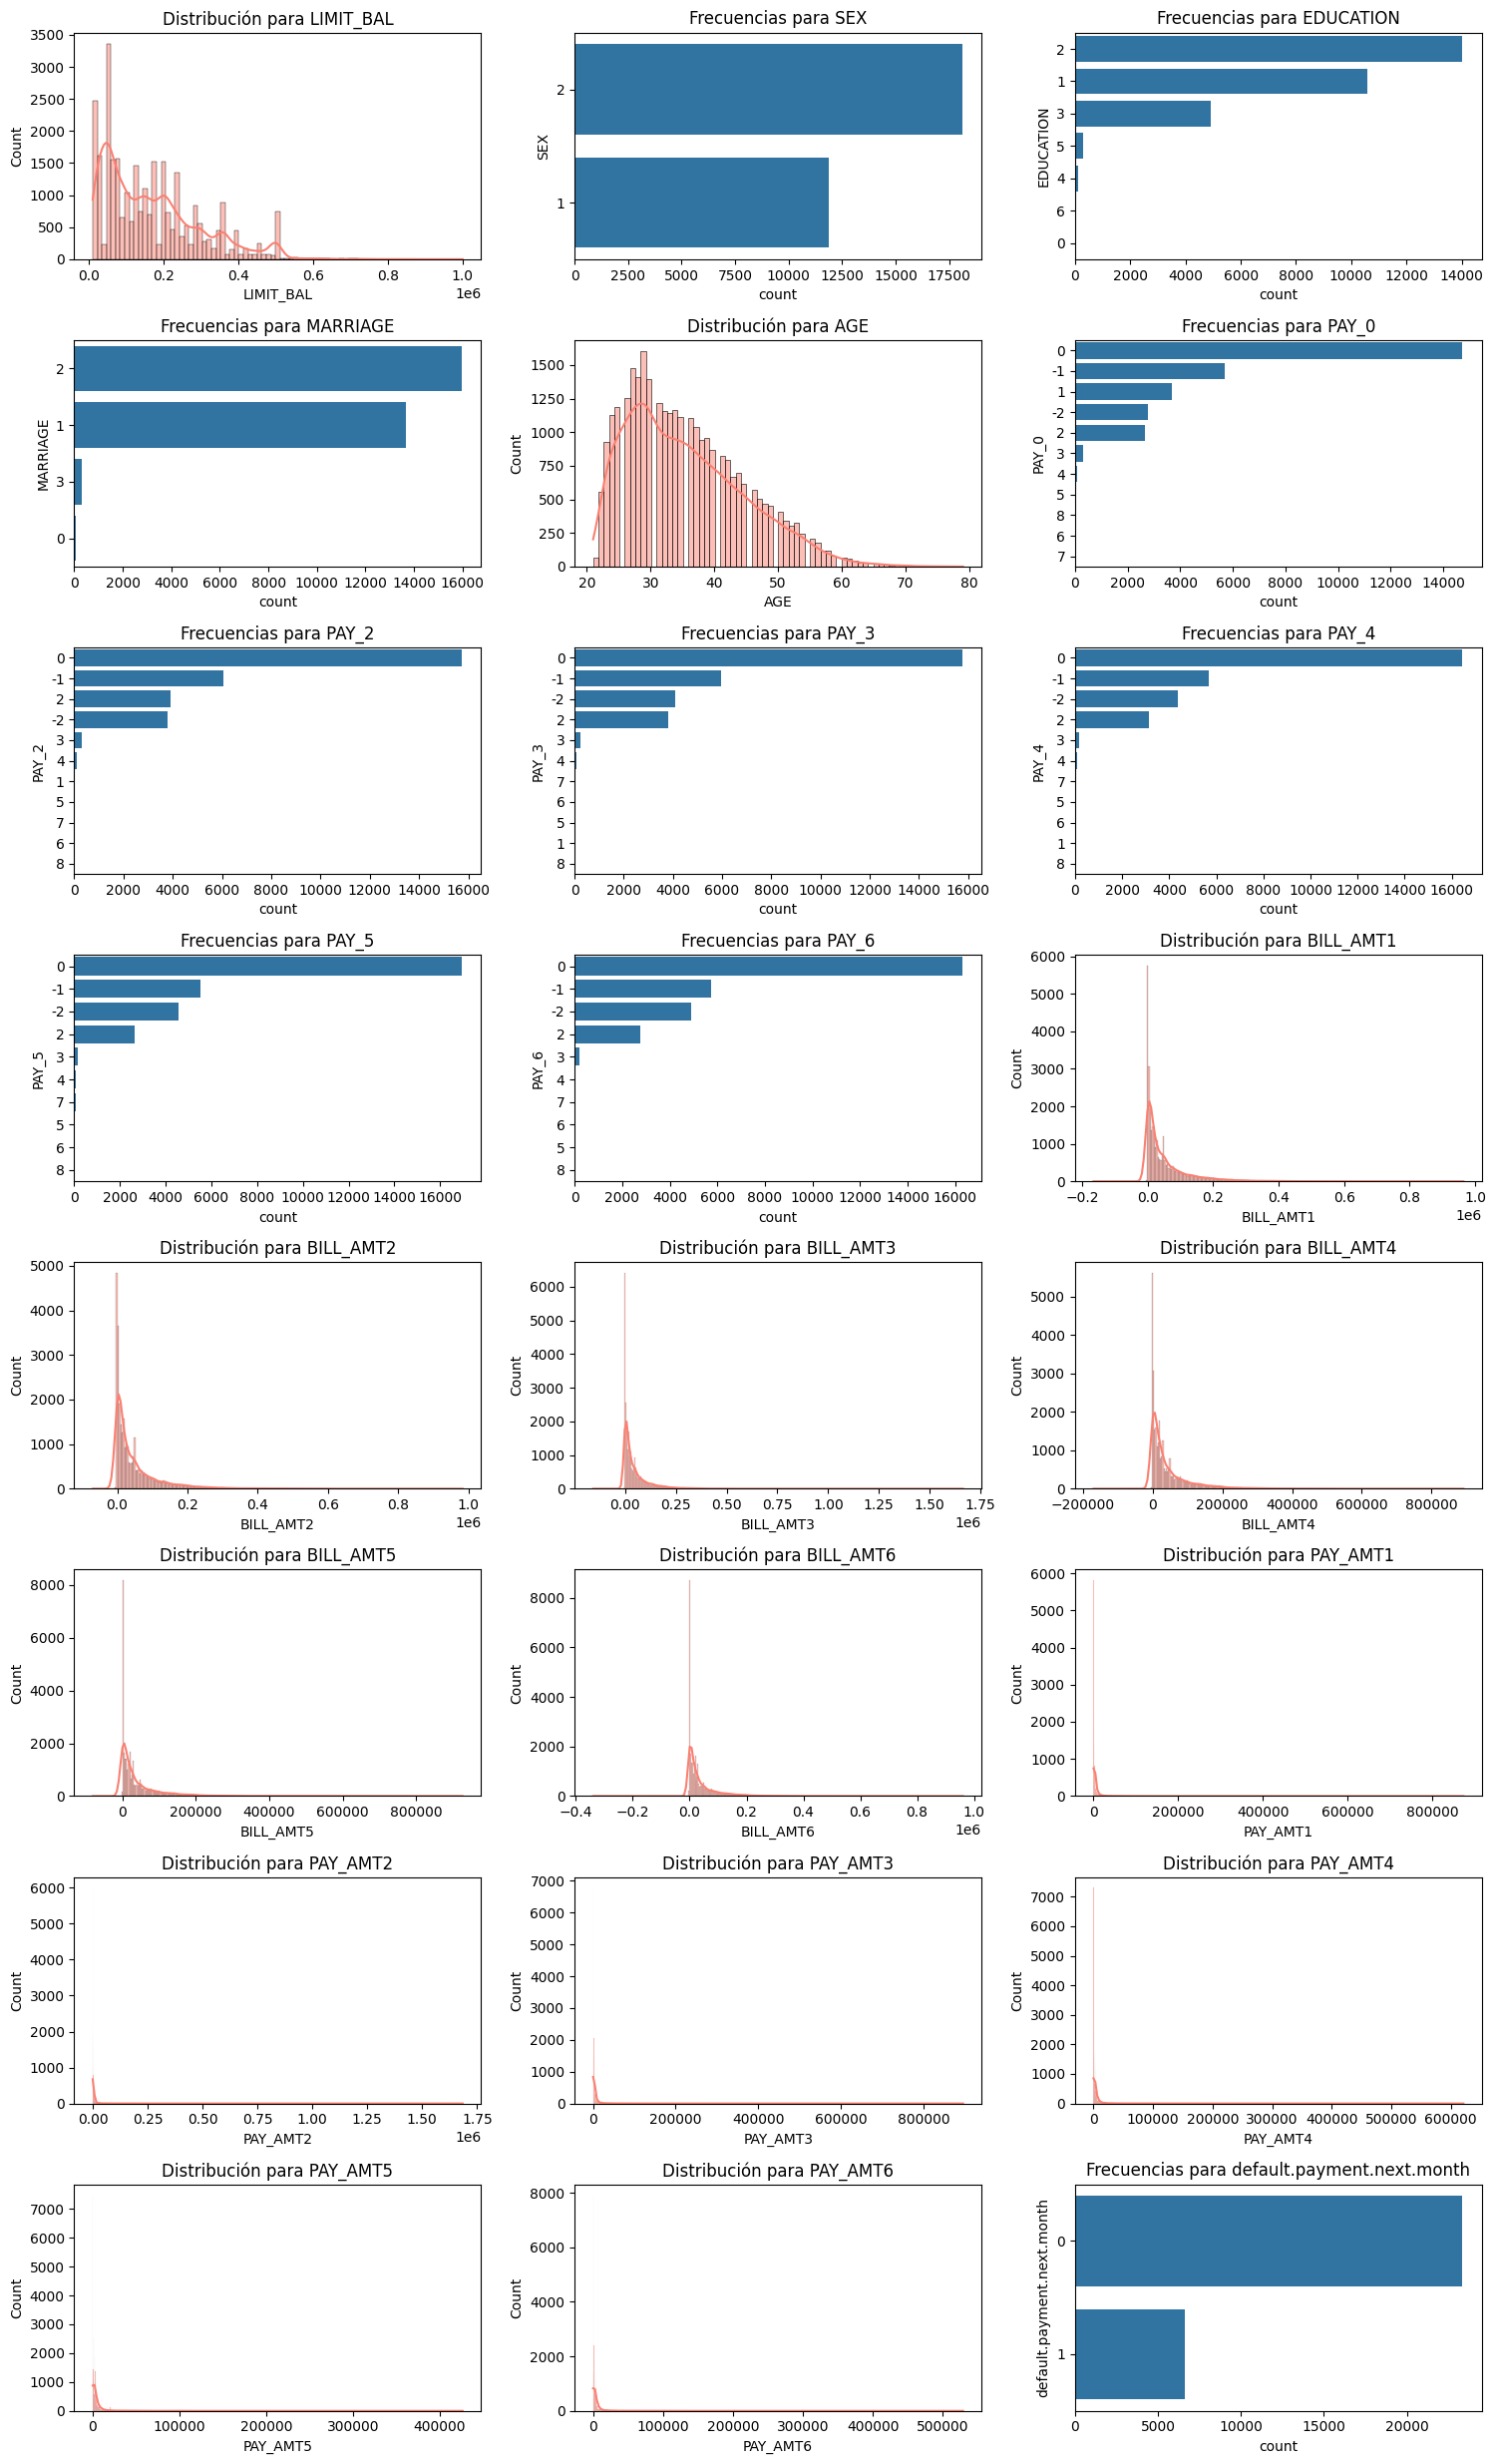

In [9]:
graficos(calidad_datos(df), df, columns)

In [10]:
df.drop(columns="ID", inplace = True)

In [11]:
df.rename(columns = {'default.payment.next.month': 'default_payment'}, inplace = True)

Correlación de Pearson entre LIMIT_BAL y default_payment: -0.15
Correlación de Pearson entre SEX y default_payment: -0.04
Correlación de Pearson entre EDUCATION y default_payment: 0.03
Correlación de Pearson entre MARRIAGE y default_payment: -0.02
Correlación de Pearson entre AGE y default_payment: 0.01
Correlación de Pearson entre PAY_0 y default_payment: 0.32
Correlación de Pearson entre PAY_2 y default_payment: 0.26
Correlación de Pearson entre PAY_3 y default_payment: 0.24
Correlación de Pearson entre PAY_4 y default_payment: 0.22
Correlación de Pearson entre PAY_5 y default_payment: 0.20
Correlación de Pearson entre PAY_6 y default_payment: 0.19
Correlación de Pearson entre BILL_AMT1 y default_payment: -0.02
Correlación de Pearson entre BILL_AMT2 y default_payment: -0.01
Correlación de Pearson entre BILL_AMT3 y default_payment: -0.01
Correlación de Pearson entre BILL_AMT4 y default_payment: -0.01
Correlación de Pearson entre BILL_AMT5 y default_payment: -0.01
Correlación de Pearso

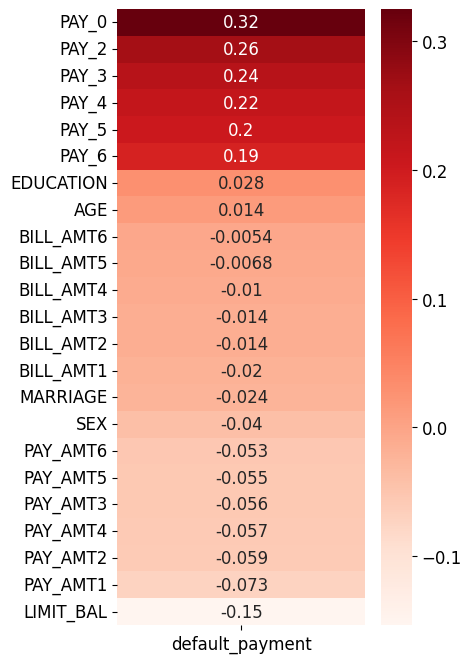

In [12]:
numeric_features, categorical_features = correlacion(df, 'default_payment', True)

In [13]:
cols_continuas = numeric_features

In [14]:
cols_continuas

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default_payment']

In [ ]:
cols_continuas.remove("SEX")
cols_continuas.remove("EDUCATION")
cols_continuas.remove("MARRIAGE")
cols_continuas.remove("PAY_0")

In [16]:
cols_continuas.remove("PAY_2")
cols_continuas.remove("PAY_3")
cols_continuas.remove("PAY_4")
cols_continuas.remove("PAY_5")
cols_continuas.remove("PAY_6")
cols_continuas.remove("default_payment")

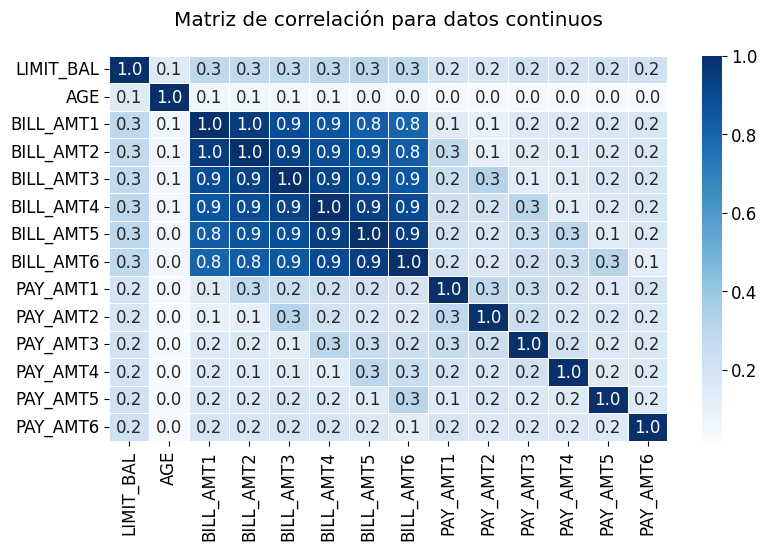

In [17]:
matriz_correlacion(df, cols_continuas)

In [18]:
calidad_datos(df)

,tipo,nan,porcentaje_nan,ceros,porcentaje_ceros,count,mean,std,min,25%,50%,75%,max,range,IQR,lim_inf,lim_sup,atipicos
default_payment,int64,0,0.0,23364,77.880000,30000.0,0.221200,0.415062,0.0,0.00,0.0,0.00,1.0,1.0,0.00,0.000,0.000,6636
SEX,int64,0,0.0,0,0.000000,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0,1.0,1.00,-0.500,3.500,0
EDUCATION,int64,0,0.0,14,0.046667,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0,6.0,1.00,-0.500,3.500,454
MARRIAGE,int64,0,0.0,54,0.180000,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0,3.0,1.00,-0.500,3.500,0
AGE,int64,0,0.0,0,0.000000,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0,58.0,13.00,8.500,60.500,272
PAY_0,int64,0,0.0,14737,49.123333,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,3130
PAY_2,int64,0,0.0,15730,52.433333,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,4410
PAY_3,int64,0,0.0,15764,52.546667,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,4209
PAY_4,int64,0,0.0,16455,54.850000,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,3508
PAY_5,int64,0,0.0,16947,56.490000,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,2968


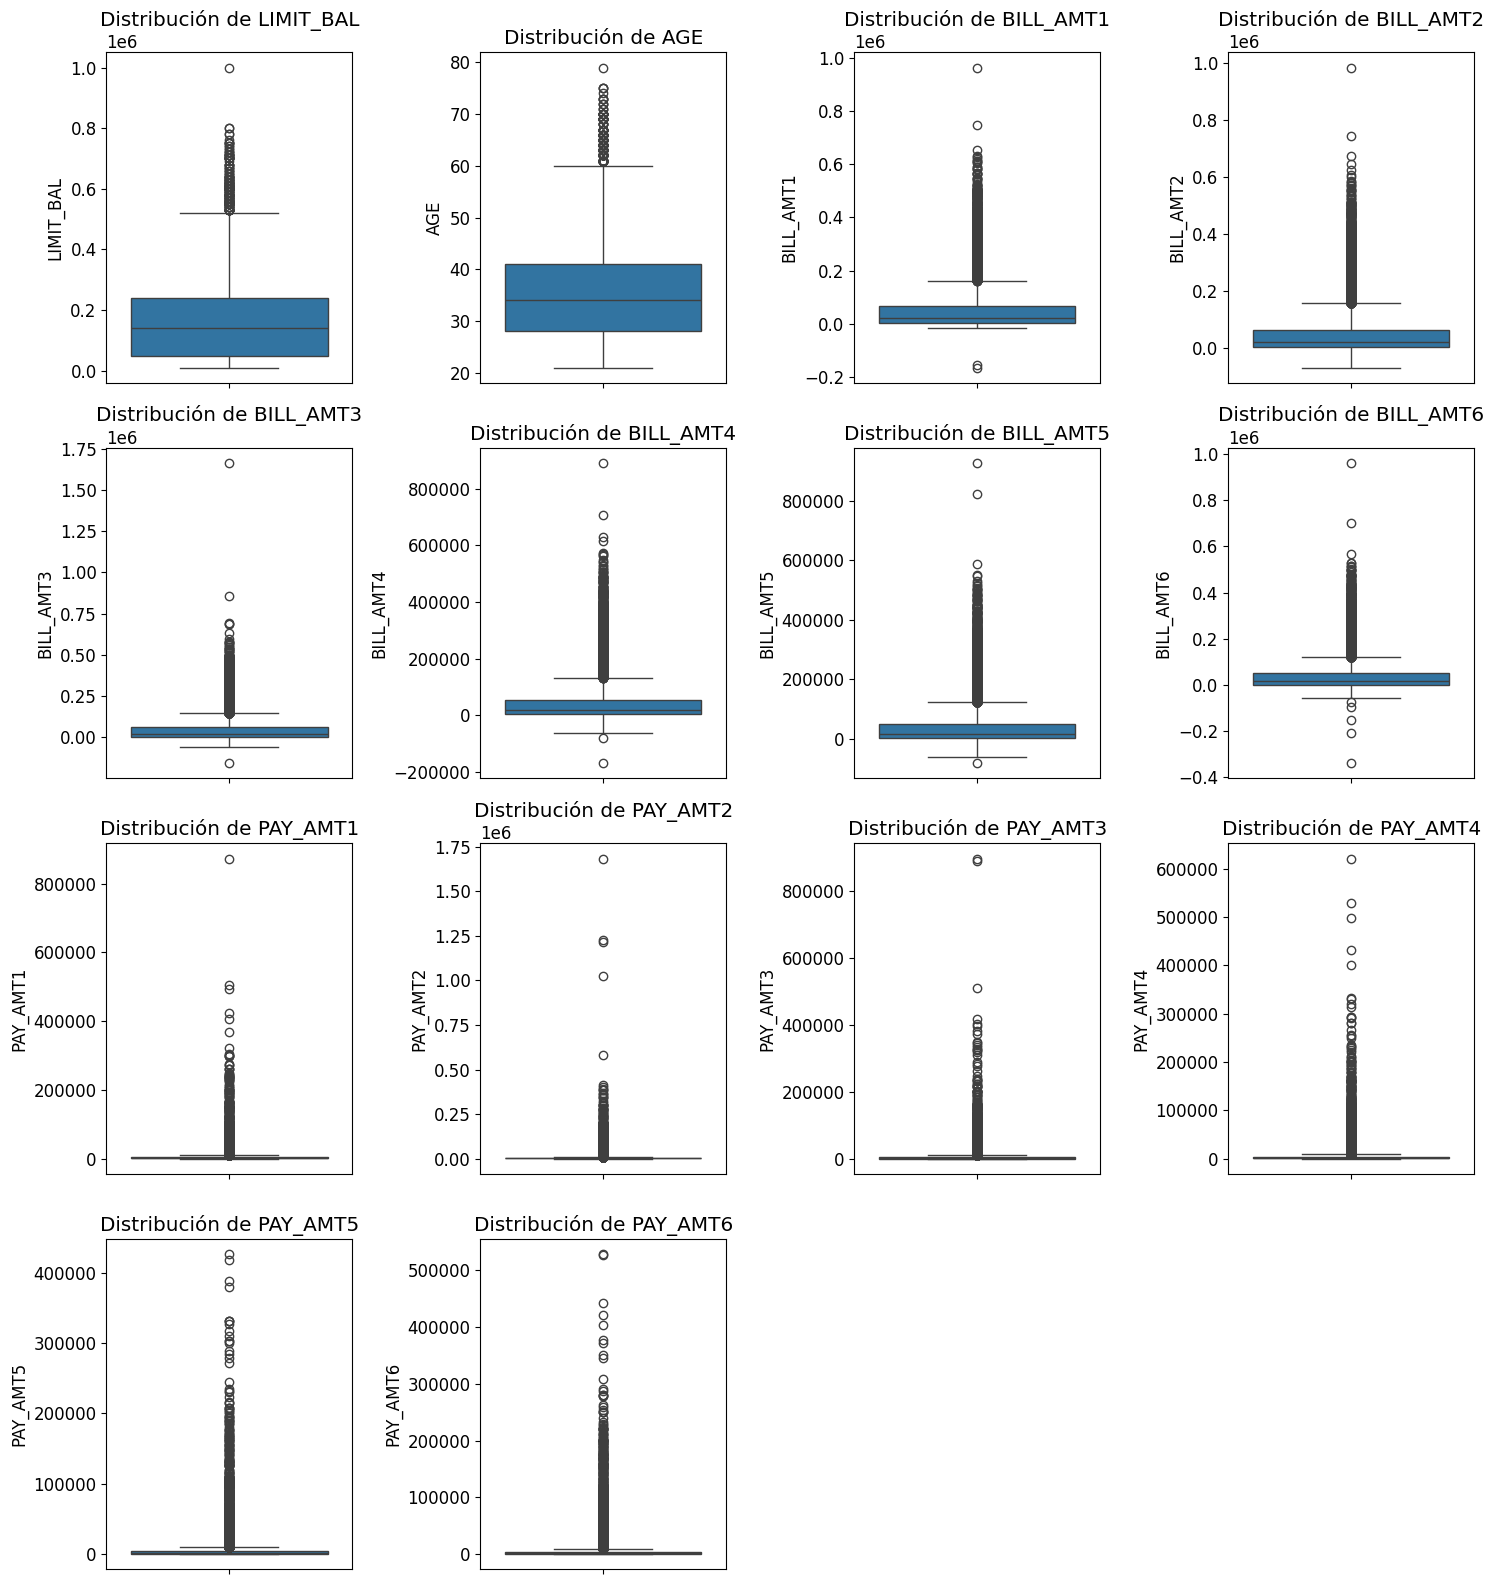

In [19]:
boxplots(df, cols_continuas)

2. Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando búsqueda por grilla con 5 kfold:

<center>max_depth: [5, 10, 15, 20, 25]</center>

<center>min_samples_split: [0.01, 0.02, 0.03, 0.04]</center>

> Da a conocer los mejores hiper parámetros encontrados y el desempeño del modelo, tanto en los datos de entrenamiento como en los de test.




In [20]:
df.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


In [21]:
RSTATE = 201235

X = df.drop(columns=['default_payment'], axis=1)
y = df['default_payment']

In [22]:
X.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0


In [23]:
calidad_datos(X)

,tipo,nan,porcentaje_nan,ceros,porcentaje_ceros,count,mean,std,min,25%,50%,75%,max,range,IQR,lim_inf,lim_sup,atipicos
SEX,int64,0,0.0,0,0.000000,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0,1.0,1.00,-0.500,3.500,0
EDUCATION,int64,0,0.0,14,0.046667,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0,6.0,1.00,-0.500,3.500,454
MARRIAGE,int64,0,0.0,54,0.180000,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0,3.0,1.00,-0.500,3.500,0
AGE,int64,0,0.0,0,0.000000,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0,58.0,13.00,8.500,60.500,272
PAY_0,int64,0,0.0,14737,49.123333,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,3130
PAY_2,int64,0,0.0,15730,52.433333,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,4410
PAY_3,int64,0,0.0,15764,52.546667,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,4209
PAY_4,int64,0,0.0,16455,54.850000,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,3508
PAY_5,int64,0,0.0,16947,56.490000,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,2968
PAY_6,int64,0,0.0,16286,54.286667,30000.0,-0.291100,1.149988,-2.0,-1.00,0.0,0.00,8.0,10.0,1.00,-2.500,1.500,3079


In [25]:
from moduls.transformacion import escalado

In [29]:
calidad_datos(X)[calidad_datos(X)["tipo"] == "float64"].index 

Index(['LIMIT_BAL', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1',
       'BILL_AMT6', 'BILL_AMT1', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2',
       'PAY_AMT5', 'BILL_AMT5', 'PAY_AMT6'],
      dtype='object')

In [30]:
columnas_a_escalar = calidad_datos(X)[calidad_datos(X)["tipo"] == "float64"].index 

In [31]:
X = escalado(X, columnas_a_escalar)

In [32]:
X.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,2,2,1,24,2,2,-1,-1,-2,-2,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,2,2,2,26,-1,2,0,0,0,2,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.33, random_state=RSTATE)
print(f'Train {X_train.shape}')
print(f'Test {X_test.shape}')

Train (9900, 23)
Test (20100, 23)


In [34]:
# criterio 'gini' (o impureza 'gini'): Métrica para determinar la mejor manera de dividir los nodos en un árbol de decisión durante 
# su construcción. Mide la impureza de un conjunto de datos
#índice de Gini de 0 indica pureza perfecta, todas las instancias del nodo pertenencen a la misma clase
#índice de Gini de 1 (o 0.5 en clasificación binaria), indica alta impureza, las clases están distribuidas de manera uniforme
model0 = DecisionTreeClassifier(criterion='gini', random_state=RSTATE)
model0.fit(X_train, y_train)

yhat_train = model0.predict(X_train)
yhat_test = model0.predict(X_test)
print('Desempeño en datos de entrenamiento')
print(classification_report(y_train, yhat_train))

print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))


Desempeño en datos de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7732
           1       1.00      1.00      1.00      2168

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900


Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.83      0.82      0.82     15632
           1       0.39      0.41      0.40      4468

    accuracy                           0.72     20100
   macro avg       0.61      0.61      0.61     20100
weighted avg       0.73      0.72      0.73     20100



In [35]:
%%time
model0 = DecisionTreeClassifier(criterion='gini', random_state=RSTATE, )
param_grid = {
    'max_depth': np.linspace(5, 25, 5, dtype='int'),
    'min_samples_split': np.linspace(0.01, 0.04, 4)
}
grid_model1 = GridSearchCV(
    DecisionTreeClassifier(random_state=RSTATE),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
grid_model1.fit(X_train, y_train)


CPU times: total: 1.09 s
Wall time: 6.6 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=201235),
             n_jobs=-1,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'min_samples_split': array([0.01, 0.02, 0.03, 0.04])})

In [36]:
print(grid_model1.best_params_)
print(grid_model1.best_score_)


{'max_depth': np.int64(5), 'min_samples_split': np.float64(0.04)}
0.8219191919191919


In [37]:
model1 = grid_model1.best_estimator_
model1.fit(X_train, y_train)

yhat_train = model1.predict(X_train)
yhat_test = model1.predict(X_test)
print('Desempeño en datos de entrenamiento')
print(classification_report(y_train, yhat_train))

print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))


Desempeño en datos de entrenamiento
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7732
           1       0.68      0.37      0.48      2168

    accuracy                           0.82      9900
   macro avg       0.76      0.66      0.69      9900
weighted avg       0.81      0.82      0.80      9900


Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     15632
           1       0.68      0.36      0.47      4468

    accuracy                           0.82     20100
   macro avg       0.76      0.66      0.68     20100
weighted avg       0.80      0.82      0.80     20100



3. Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

In [38]:
from imblearn.over_sampling import SMOTE #pip install imbalanced-learn

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()


default_payment
0    7732
1    7732
Name: count, dtype: int64

In [39]:
# se entrena un modelo Bagging con 200 árboles

bagging_hom = BaggingClassifier(n_estimators=200)
bagging_hom.fit(X_train_resampled, y_train_resampled)

yhat_test = model1.predict(X_test)
print('\nDesempeño en datos de test')
print(classification_report(y_test, yhat_test))



Desempeño en datos de test
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     15632
           1       0.68      0.36      0.47      4468

    accuracy                           0.82     20100
   macro avg       0.76      0.66      0.68     20100
weighted avg       0.80      0.82      0.80     20100



4. Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel **rbf** y **sigmoid**. Para ello considera 200 muestras bootstrap (T).

> Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más importante en la lista de modelos a entrenar. Considera que un mejor modelo es aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el archivo **util_bagging.py**)

In [40]:
import moduls.util_bagging as ubagging

###
# Ponderaciones
###

# LogisticRegression(max_iter=1000) -> 16.6%
# DecisionTreeClassifier()          -> 50.0%
# SVC(kernel='rbf', C=2.4)          -> 16.6%
# SVC(kernel='sigmoid', C=0.39)     -> 16.6%

estimators = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=2.4),
    SVC(kernel='sigmoid', C=0.39)
]

trained_model, resultados, yhat, idx_oob = ubagging.bagging_het(X_train_resampled, y_train_resampled, 200, estimators, X_test)
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.86      0.81      0.84     15632
           1       0.45      0.55      0.50      4468

    accuracy                           0.75     20100
   macro avg       0.66      0.68      0.67     20100
weighted avg       0.77      0.75      0.76     20100



5. Implementa un modelo de ensamble Random Forest usando como hiper parámetro **n_estimators = 45**. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

In [41]:
model2 = RandomForestClassifier(n_estimators=45, oob_score=True, random_state=RSTATE, n_jobs=-1)
model2.fit(X_train, y_train)

yhat_test = model2.predict(X_test)
print(classification_report(y_test, yhat_test))


              precision    recall  f1-score   support

           0       0.84      0.93      0.88     15632
           1       0.62      0.37      0.46      4468

    accuracy                           0.81     20100
   macro avg       0.73      0.65      0.67     20100
weighted avg       0.79      0.81      0.79     20100



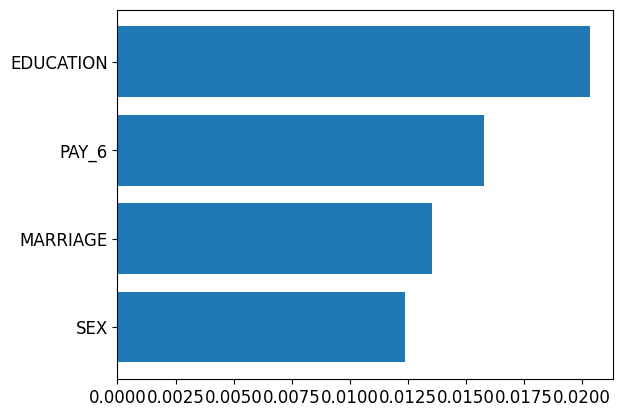

In [42]:
# visualizar importancia de los atributos del modelo
idx_sort = np.argsort(model2.feature_importances_)[:4]
plt.barh(y=model2.feature_names_in_[idx_sort], width=model2.feature_importances_[idx_sort]);


In [43]:
model2.oob_score_

0.8094949494949495

6. Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:
<center> <strong> n_estimators:</strong> 50 a 300 con paso de 25 </center>
<center><strong>max_features:</strong> [‘sqrt’, ‘log2’, None]</center>

Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido estos? Analiza  además las métricas de desempeño,  ROC y AUC.


In [44]:
%%time
param_grid = {
    'n_estimators': np.linspace(50, 300, 25, dtype='int'),
    'max_features': ['sqrt', 'log2', None]
}
grid_model3 = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=RSTATE),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
grid_model3.fit(X_train, y_train)


CPU times: total: 14.3 s
Wall time: 15min 9s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=201235),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': array([ 50,  60,  70,  81,  91, 102, 112, 122, 133, 143, 154, 164, 175,
       185, 195, 206, 216, 227, 237, 247, 258, 268, 279, 289, 300])})

In [45]:
print(grid_model3.best_params_)
print(grid_model3.best_estimator_.oob_score_)


{'max_features': 'sqrt', 'n_estimators': np.int64(195)}
0.8168686868686869


In [46]:
model3 = grid_model3.best_estimator_

yhat_test = model3.predict(X_test)
print(classification_report(y_test, yhat_test))


              precision    recall  f1-score   support

           0       0.84      0.94      0.89     15632
           1       0.63      0.38      0.47      4468

    accuracy                           0.81     20100
   macro avg       0.74      0.66      0.68     20100
weighted avg       0.79      0.81      0.79     20100



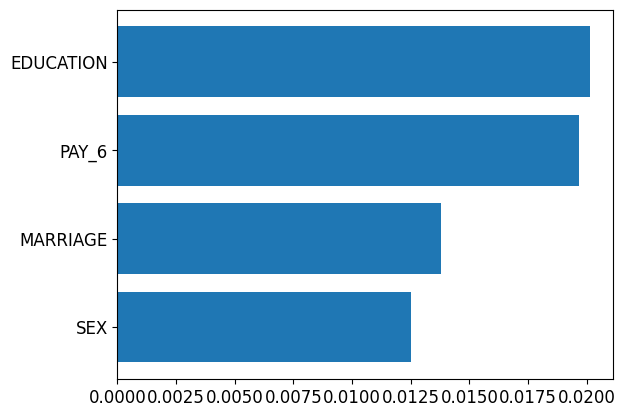

In [47]:
# visualizar importancia de los atributos del modelo
idx_sort = np.argsort(model3.feature_importances_)[:4]
plt.barh(y=model3.feature_names_in_[idx_sort], width=model3.feature_importances_[idx_sort]);


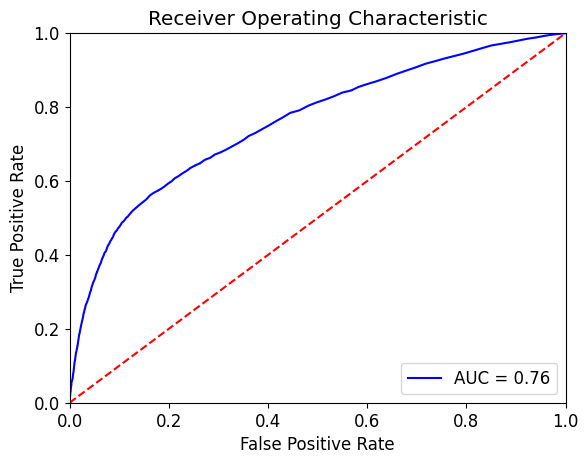

In [48]:
yhat_proba_test = model3.predict_proba(X_test) # probabilidades de clase para cada instancia en conjunto de prueba
fpr, tpr, threshold = roc_curve(y_test, yhat_proba_test[:,1]) # curva ROC
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


7. Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a no pagar la tarjeta de crédito el próximo mes

In [49]:
N = 15
yhat = model3.predict_proba(X)[:,1] # probabilidades de clase positiva
df_client = df.copy()
df_client['proba'] = yhat

#np.argsort(yhat): devuelve los índices que ordenarían el array yhat de forma ascendente
#[::-1] invierte el array de índices
sort_idx = np.argsort(yhat)[::-1]
df_client = df_client.iloc[sort_idx,]
df_client.head(N)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment,proba
18135,10000.0,1,3,2,46,3,2,2,3,3,3,1050.0,1050.0,1050.0,1050.0,1050.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000
11739,300000.0,2,1,1,47,2,2,2,2,2,2,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994872
19982,300000.0,2,1,1,47,3,2,2,2,2,2,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994872
14244,10000.0,1,2,1,50,2,2,7,7,7,7,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994872
27536,250000.0,1,1,1,51,3,2,2,2,2,2,2487.0,2487.0,2487.0,2487.0,2487.0,2487.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994872
14950,250000.0,1,1,1,51,2,2,2,2,2,2,2487.0,2487.0,2487.0,2487.0,2487.0,2487.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.989744
14220,70000.0,2,2,2,42,2,2,2,2,2,2,44689.0,45669.0,46621.0,45573.0,48678.0,47744.0,2000.0,2000.0,0.0,4000.0,0.0,2000.0,1,0.989744
12955,280000.0,2,1,2,62,2,2,2,2,2,2,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.989744
4006,10000.0,1,3,2,46,2,2,3,3,3,3,1050.0,1050.0,1050.0,1050.0,1050.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.989744
16489,30000.0,1,2,2,22,3,2,2,3,3,3,1050.0,1050.0,1050.0,1050.0,1050.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.989744
